In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from torch.utils.data import TensorDataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA

In [3]:
class CNN2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dense1 = nn.Linear(32*14*14, 128)
    self.dense2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = x.view(x.shape[0], -1)
    x = self.dense1(x)
    x = self.dense2(x)
    out = F.log_softmax(x)
    return out

In [4]:
class Trainer:

    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: None,
                 # lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False,
                 path2write: str = None,
                 save_best=False,
                 save_final=True,
                 save_interval=10,
                 checkpoint_start_epoch=50
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        # self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        #             if self.notebook:
        #                 print('Notebook')
        #                 from tqdm.notebook import tqdm, trange
        #             else:
        #                 from tqdm import tqdm, trange
        self.path2write = path2write
        LOG_DIR = os.path.join(path2write, 'Log')  # path2write + 'Log/'
        self.writer_train = SummaryWriter(os.path.join(LOG_DIR, "train"))
        self.writer_val = SummaryWriter(os.path.join(LOG_DIR, "val"))
        self.check_point_path = os.path.join(path2write, 'check_points')
        if not os.path.exists(self.check_point_path):
            os.makedirs(self.check_point_path)
        self.save_best = save_best
        self.save_final = save_final
        self.save_interval = save_interval
        self.checkpoint_start_epoch = checkpoint_start_epoch
        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []
        self.training_accuracy = []
        self.validation_accuracy = []

    def run_trainer(self):
        self.model.to(self.device)
        #         print(next(self.model.parameters()).device)
        if self.notebook:
            print('Notebook')
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange
        #         print(self.epochs)
        progressbar = trange(self.epochs, desc='Progress', disable=True)  # don't show progressbar
        loss_max = None
        for epoch in progressbar:
            print(f'Epoch - {epoch}')

            # Training Block
            train_loss, train_accuracy = self._train()
            self.writer_train.add_scalar("Train Loss", train_loss, epoch)
            self.writer_train.add_scalar("Train Accuracy", train_accuracy, epoch)


            # Val Block
            val_loss, val_accuracy = self._validate()
            self.writer_val.add_scalar("Val Loss", val_loss, epoch)
            self.writer_val.add_scalar("Val Accuracy", val_accuracy, epoch)

            # lr
            self.writer_train.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], epoch)

            print('Epoch - {} Train Loss - {:.6f} Val Loss - {:.6f} Train Accuracy - {:.6f} Val Accuracy - {:.6f}'.format(epoch, train_loss, val_loss, train_accuracy, val_accuracy))
            if self.save_final:
                if epoch == self.epochs-1:
                    model_name = 'epoch-{}-loss{:.6f}'.format(epoch, val_loss)
                    torch.save(self.model.state_dict(), os.path.join(self.check_point_path, model_name))
            loss_max = val_loss

        return self.training_loss, self.validation_loss, self.model, self.training_accuracy, self.validation_accuracy

    def _train(self):

        self.model.train()
        train_losses = []
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          disable=False)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.type(torch.float32).to(self.device)
            self.optimizer.zero_grad()
            target = target.type(torch.LongTensor).to(self.device)
            output = self.model(input)
            loss = self.criterion(output, target)
            train_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
            pred = output.argmax(dim=1, keepdim=True) # max of prob
            pred = pred.flatten()
            batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor))
        accuracy = batch_acc/len(self.training_DataLoader)
        self.training_loss.append(np.mean(train_losses))  # Mean batch loss
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])
        self.training_accuracy.append(accuracy)

        batch_iter.close()  # clean up the bar
        return np.mean(train_losses), accuracy

    def _validate(self):

        self.model.eval()
        valid_losses = []
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'validation', total=len(self.validation_DataLoader), disable=False)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.to(self.device)
            with torch.no_grad():
                output = self.model(input)
                target = target.type(torch.LongTensor).to(self.device)
                loss = self.criterion(output, target)
                valid_losses.append(loss.item())
                pred = output.argmax(dim=1, keepdim=True)
                batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor)).item()

        accuracy = batch_acc/len(self.validation_DataLoader)
        self.validation_loss.append(np.mean(valid_losses))
        self.validation_accuracy.append(accuracy)
        batch_iter.close()
        return np.mean(valid_losses), accuracy

In [5]:
bath_size = 1020

transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('Home work', train=True, download=True, transform=transform)
random.shuffle(dataset1.targets)

dataset2 = datasets.MNIST('Home work', train=False, transform=transform)

training_DataLoader = DataLoader(dataset1, batch_size=bath_size, shuffle=True)
validation_DataLoader= DataLoader(dataset2, batch_size=bath_size, shuffle=True)

In [6]:
path2write = os.path.expanduser("~/my_logs")  # This will create a 'my_logs' directory in your home directory


In [7]:
gpu_id = 0
loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
epochs =  100
notebook = True
checkpoint_start_epoch = 5 #Not using
path2write = "drive/MyDrive/DL_homework/HW1_1/CNN/"

In [8]:
model = CNN2()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
trainer = Trainer(model=model,
                      device=gpu_id,
                      criterion=loss_fn,
                      optimizer=optimizer,
                      training_DataLoader=training_DataLoader,
                      validation_DataLoader=validation_DataLoader,
                      # lr_scheduler=lr_scheduler,
                      epochs=epochs,
                      epoch=0,
                      notebook=True,
                      path2write= path2write,
                      checkpoint_start_epoch=checkpoint_start_epoch )
training_loss, validation_loss, model, training_accuracy, validation_accuracy = trainer.run_trainer()

Notebook
Epoch - 0


Training:   0%|          | 0/59 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_656721/979612184.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)
validation: 100%|██████████| 10/10 [00:00<00:00, 14.41it/s]


Epoch - 0 Train Loss - 2.304938 Val Loss - 2.299759 Train Accuracy - 0.107497 Val Accuracy - 0.144101
Epoch - 1


validation: 100%|██████████| 10/10 [00:00<00:00, 14.53it/s]


Epoch - 1 Train Loss - 2.300900 Val Loss - 2.300396 Train Accuracy - 0.112673 Val Accuracy - 0.116688
Epoch - 2


validation: 100%|██████████| 10/10 [00:00<00:00, 14.48it/s]


Epoch - 2 Train Loss - 2.299661 Val Loss - 2.302871 Train Accuracy - 0.115169 Val Accuracy - 0.116461
Epoch - 3


validation: 100%|██████████| 10/10 [00:00<00:00, 14.34it/s]


Epoch - 3 Train Loss - 2.298553 Val Loss - 2.301392 Train Accuracy - 0.116994 Val Accuracy - 0.118955
Epoch - 4


validation: 100%|██████████| 10/10 [00:00<00:00, 14.33it/s]


Epoch - 4 Train Loss - 2.296604 Val Loss - 2.303680 Train Accuracy - 0.119392 Val Accuracy - 0.109012
Epoch - 5


validation: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


Epoch - 5 Train Loss - 2.296584 Val Loss - 2.298050 Train Accuracy - 0.119807 Val Accuracy - 0.124450
Epoch - 6


validation: 100%|██████████| 10/10 [00:00<00:00, 14.51it/s]


Epoch - 6 Train Loss - 2.294136 Val Loss - 2.300189 Train Accuracy - 0.122716 Val Accuracy - 0.131035
Epoch - 7


validation: 100%|██████████| 10/10 [00:00<00:00, 14.44it/s]


Epoch - 7 Train Loss - 2.292861 Val Loss - 2.301884 Train Accuracy - 0.125551 Val Accuracy - 0.130703
Epoch - 8


validation: 100%|██████████| 10/10 [00:00<00:00, 14.38it/s]


Epoch - 8 Train Loss - 2.291568 Val Loss - 2.300948 Train Accuracy - 0.127942 Val Accuracy - 0.118034
Epoch - 9


validation: 100%|██████████| 10/10 [00:00<00:00, 14.60it/s]


Epoch - 9 Train Loss - 2.289695 Val Loss - 2.296834 Train Accuracy - 0.127760 Val Accuracy - 0.132461
Epoch - 10


validation: 100%|██████████| 10/10 [00:00<00:00, 14.36it/s]


Epoch - 10 Train Loss - 2.288512 Val Loss - 2.298048 Train Accuracy - 0.130982 Val Accuracy - 0.134780
Epoch - 11


validation: 100%|██████████| 10/10 [00:00<00:00, 14.50it/s]


Epoch - 11 Train Loss - 2.287435 Val Loss - 2.300328 Train Accuracy - 0.132506 Val Accuracy - 0.138376
Epoch - 12


validation: 100%|██████████| 10/10 [00:00<00:00, 14.30it/s]


Epoch - 12 Train Loss - 2.286186 Val Loss - 2.297171 Train Accuracy - 0.132696 Val Accuracy - 0.161320
Epoch - 13


validation: 100%|██████████| 10/10 [00:00<00:00, 14.43it/s]


Epoch - 13 Train Loss - 2.284959 Val Loss - 2.301271 Train Accuracy - 0.134168 Val Accuracy - 0.139151
Epoch - 14


validation: 100%|██████████| 10/10 [00:00<00:00, 14.47it/s]


Epoch - 14 Train Loss - 2.283322 Val Loss - 2.302405 Train Accuracy - 0.135092 Val Accuracy - 0.100949
Epoch - 15


validation: 100%|██████████| 10/10 [00:00<00:00, 14.59it/s]


Epoch - 15 Train Loss - 2.282297 Val Loss - 2.298998 Train Accuracy - 0.135850 Val Accuracy - 0.135299
Epoch - 16


validation: 100%|██████████| 10/10 [00:00<00:00, 14.64it/s]


Epoch - 16 Train Loss - 2.280719 Val Loss - 2.301260 Train Accuracy - 0.137819 Val Accuracy - 0.139436
Epoch - 17


validation: 100%|██████████| 10/10 [00:00<00:00, 14.60it/s]


Epoch - 17 Train Loss - 2.279542 Val Loss - 2.298573 Train Accuracy - 0.140458 Val Accuracy - 0.124696
Epoch - 18


validation: 100%|██████████| 10/10 [00:00<00:00, 14.49it/s]


Epoch - 18 Train Loss - 2.278602 Val Loss - 2.300603 Train Accuracy - 0.141134 Val Accuracy - 0.128247
Epoch - 19


validation: 100%|██████████| 10/10 [00:00<00:00, 14.65it/s]


Epoch - 19 Train Loss - 2.276999 Val Loss - 2.295793 Train Accuracy - 0.143322 Val Accuracy - 0.137217
Epoch - 20


validation: 100%|██████████| 10/10 [00:00<00:00, 10.79it/s]


Epoch - 20 Train Loss - 2.274531 Val Loss - 2.298306 Train Accuracy - 0.144881 Val Accuracy - 0.147912
Epoch - 21


validation: 100%|██████████| 10/10 [00:00<00:00, 14.40it/s]


Epoch - 21 Train Loss - 2.274004 Val Loss - 2.299864 Train Accuracy - 0.145905 Val Accuracy - 0.108185
Epoch - 22


validation: 100%|██████████| 10/10 [00:00<00:00, 14.40it/s]


Epoch - 22 Train Loss - 2.273165 Val Loss - 2.303583 Train Accuracy - 0.145389 Val Accuracy - 0.140371
Epoch - 23


validation: 100%|██████████| 10/10 [00:00<00:00, 14.42it/s]


Epoch - 23 Train Loss - 2.271207 Val Loss - 2.298458 Train Accuracy - 0.148589 Val Accuracy - 0.144376
Epoch - 24


validation: 100%|██████████| 10/10 [00:00<00:00, 14.43it/s]


Epoch - 24 Train Loss - 2.271198 Val Loss - 2.296942 Train Accuracy - 0.147313 Val Accuracy - 0.115093
Epoch - 25


validation: 100%|██████████| 10/10 [00:00<00:00, 14.32it/s]


Epoch - 25 Train Loss - 2.269892 Val Loss - 2.301664 Train Accuracy - 0.149580 Val Accuracy - 0.144594
Epoch - 26


validation: 100%|██████████| 10/10 [00:00<00:00, 14.34it/s]


Epoch - 26 Train Loss - 2.268017 Val Loss - 2.301313 Train Accuracy - 0.149285 Val Accuracy - 0.143003
Epoch - 27


validation: 100%|██████████| 10/10 [00:00<00:00, 14.36it/s]


Epoch - 27 Train Loss - 2.265601 Val Loss - 2.296331 Train Accuracy - 0.153195 Val Accuracy - 0.145215
Epoch - 28


validation: 100%|██████████| 10/10 [00:00<00:00, 14.38it/s]


Epoch - 28 Train Loss - 2.264967 Val Loss - 2.302847 Train Accuracy - 0.151626 Val Accuracy - 0.135765
Epoch - 29


validation: 100%|██████████| 10/10 [00:00<00:00, 14.38it/s]


Epoch - 29 Train Loss - 2.262798 Val Loss - 2.302526 Train Accuracy - 0.156340 Val Accuracy - 0.137767
Epoch - 30


validation: 100%|██████████| 10/10 [00:00<00:00, 14.32it/s]


Epoch - 30 Train Loss - 2.261678 Val Loss - 2.311322 Train Accuracy - 0.157006 Val Accuracy - 0.123372
Epoch - 31


validation: 100%|██████████| 10/10 [00:00<00:00, 14.38it/s]


Epoch - 31 Train Loss - 2.259582 Val Loss - 2.306832 Train Accuracy - 0.157164 Val Accuracy - 0.137183
Epoch - 32


validation: 100%|██████████| 10/10 [00:00<00:00, 14.62it/s]


Epoch - 32 Train Loss - 2.259046 Val Loss - 2.309936 Train Accuracy - 0.157901 Val Accuracy - 0.105933
Epoch - 33


validation: 100%|██████████| 10/10 [00:00<00:00, 14.58it/s]


Epoch - 33 Train Loss - 2.257546 Val Loss - 2.302393 Train Accuracy - 0.160694 Val Accuracy - 0.136590
Epoch - 34


validation: 100%|██████████| 10/10 [00:00<00:00, 14.66it/s]


Epoch - 34 Train Loss - 2.256213 Val Loss - 2.312559 Train Accuracy - 0.159475 Val Accuracy - 0.127783
Epoch - 35


validation: 100%|██████████| 10/10 [00:00<00:00, 14.60it/s]


Epoch - 35 Train Loss - 2.253788 Val Loss - 2.300209 Train Accuracy - 0.162560 Val Accuracy - 0.152236
Epoch - 36


validation: 100%|██████████| 10/10 [00:00<00:00, 14.40it/s]


Epoch - 36 Train Loss - 2.253529 Val Loss - 2.296314 Train Accuracy - 0.160507 Val Accuracy - 0.140780
Epoch - 37


validation: 100%|██████████| 10/10 [00:00<00:00, 14.40it/s]


Epoch - 37 Train Loss - 2.250139 Val Loss - 2.296505 Train Accuracy - 0.164415 Val Accuracy - 0.155440
Epoch - 38


validation: 100%|██████████| 10/10 [00:00<00:00, 14.40it/s]


Epoch - 38 Train Loss - 2.250790 Val Loss - 2.307255 Train Accuracy - 0.163819 Val Accuracy - 0.124132
Epoch - 39


validation: 100%|██████████| 10/10 [00:00<00:00, 14.41it/s]


Epoch - 39 Train Loss - 2.247420 Val Loss - 2.310649 Train Accuracy - 0.165985 Val Accuracy - 0.131875
Epoch - 40


validation: 100%|██████████| 10/10 [00:00<00:00, 14.45it/s]


Epoch - 40 Train Loss - 2.246889 Val Loss - 2.319000 Train Accuracy - 0.165857 Val Accuracy - 0.125825
Epoch - 41


validation: 100%|██████████| 10/10 [00:00<00:00, 10.69it/s]


Epoch - 41 Train Loss - 2.244687 Val Loss - 2.318495 Train Accuracy - 0.169604 Val Accuracy - 0.124778
Epoch - 42


validation: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


Epoch - 42 Train Loss - 2.242921 Val Loss - 2.322027 Train Accuracy - 0.167733 Val Accuracy - 0.142606
Epoch - 43


validation: 100%|██████████| 10/10 [00:00<00:00, 14.44it/s]


Epoch - 43 Train Loss - 2.243337 Val Loss - 2.321789 Train Accuracy - 0.168689 Val Accuracy - 0.142678
Epoch - 44


validation: 100%|██████████| 10/10 [00:00<00:00, 14.44it/s]


Epoch - 44 Train Loss - 2.240211 Val Loss - 2.306240 Train Accuracy - 0.171063 Val Accuracy - 0.148336
Epoch - 45


validation: 100%|██████████| 10/10 [00:00<00:00, 14.43it/s]


Epoch - 45 Train Loss - 2.238384 Val Loss - 2.317609 Train Accuracy - 0.173855 Val Accuracy - 0.136796
Epoch - 46


validation: 100%|██████████| 10/10 [00:00<00:00, 14.41it/s]


Epoch - 46 Train Loss - 2.237351 Val Loss - 2.321396 Train Accuracy - 0.173332 Val Accuracy - 0.120794
Epoch - 47


validation: 100%|██████████| 10/10 [00:00<00:00, 14.34it/s]


Epoch - 47 Train Loss - 2.235280 Val Loss - 2.309271 Train Accuracy - 0.175265 Val Accuracy - 0.123596
Epoch - 48


validation: 100%|██████████| 10/10 [00:00<00:00, 14.47it/s]


Epoch - 48 Train Loss - 2.233427 Val Loss - 2.316048 Train Accuracy - 0.174873 Val Accuracy - 0.119943
Epoch - 49


validation: 100%|██████████| 10/10 [00:00<00:00, 14.35it/s]


Epoch - 49 Train Loss - 2.232176 Val Loss - 2.299925 Train Accuracy - 0.177250 Val Accuracy - 0.133563
Epoch - 50


validation: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


Epoch - 50 Train Loss - 2.231353 Val Loss - 2.326630 Train Accuracy - 0.176345 Val Accuracy - 0.122635
Epoch - 51


validation: 100%|██████████| 10/10 [00:00<00:00, 14.28it/s]


Epoch - 51 Train Loss - 2.228515 Val Loss - 2.318829 Train Accuracy - 0.177440 Val Accuracy - 0.125301
Epoch - 52


validation: 100%|██████████| 10/10 [00:00<00:00, 14.11it/s]


Epoch - 52 Train Loss - 2.227610 Val Loss - 2.327247 Train Accuracy - 0.179231 Val Accuracy - 0.117614
Epoch - 53


validation: 100%|██████████| 10/10 [00:00<00:00, 14.43it/s]


Epoch - 53 Train Loss - 2.224587 Val Loss - 2.319088 Train Accuracy - 0.182918 Val Accuracy - 0.136081
Epoch - 54


validation: 100%|██████████| 10/10 [00:00<00:00, 14.28it/s]


Epoch - 54 Train Loss - 2.224190 Val Loss - 2.323293 Train Accuracy - 0.180773 Val Accuracy - 0.135818
Epoch - 55


validation: 100%|██████████| 10/10 [00:00<00:00, 14.52it/s]


Epoch - 55 Train Loss - 2.222377 Val Loss - 2.327055 Train Accuracy - 0.181566 Val Accuracy - 0.118419
Epoch - 56


validation: 100%|██████████| 10/10 [00:00<00:00, 14.35it/s]


Epoch - 56 Train Loss - 2.219860 Val Loss - 2.336996 Train Accuracy - 0.181987 Val Accuracy - 0.122683
Epoch - 57


validation: 100%|██████████| 10/10 [00:00<00:00, 14.15it/s]


Epoch - 57 Train Loss - 2.219072 Val Loss - 2.336563 Train Accuracy - 0.182078 Val Accuracy - 0.123917
Epoch - 58


validation: 100%|██████████| 10/10 [00:00<00:00, 14.48it/s]


Epoch - 58 Train Loss - 2.219658 Val Loss - 2.325789 Train Accuracy - 0.181494 Val Accuracy - 0.130397
Epoch - 59


validation: 100%|██████████| 10/10 [00:00<00:00, 14.20it/s]


Epoch - 59 Train Loss - 2.214989 Val Loss - 2.313198 Train Accuracy - 0.187222 Val Accuracy - 0.129672
Epoch - 60


validation: 100%|██████████| 10/10 [00:00<00:00, 14.52it/s]


Epoch - 60 Train Loss - 2.216056 Val Loss - 2.332577 Train Accuracy - 0.184300 Val Accuracy - 0.124495
Epoch - 61


validation: 100%|██████████| 10/10 [00:00<00:00, 14.39it/s]


Epoch - 61 Train Loss - 2.212460 Val Loss - 2.343527 Train Accuracy - 0.188532 Val Accuracy - 0.120306
Epoch - 62


validation: 100%|██████████| 10/10 [00:00<00:00, 14.54it/s]


Epoch - 62 Train Loss - 2.210226 Val Loss - 2.335385 Train Accuracy - 0.189249 Val Accuracy - 0.136595
Epoch - 63


validation: 100%|██████████| 10/10 [00:00<00:00, 14.50it/s]


Epoch - 63 Train Loss - 2.209244 Val Loss - 2.338744 Train Accuracy - 0.190109 Val Accuracy - 0.123032
Epoch - 64


validation: 100%|██████████| 10/10 [00:00<00:00, 14.56it/s]


Epoch - 64 Train Loss - 2.208064 Val Loss - 2.330114 Train Accuracy - 0.189452 Val Accuracy - 0.147528
Epoch - 65


validation: 100%|██████████| 10/10 [00:00<00:00, 10.85it/s]


Epoch - 65 Train Loss - 2.205855 Val Loss - 2.344179 Train Accuracy - 0.191275 Val Accuracy - 0.129146
Epoch - 66


validation: 100%|██████████| 10/10 [00:00<00:00, 14.57it/s]


Epoch - 66 Train Loss - 2.204729 Val Loss - 2.325383 Train Accuracy - 0.192236 Val Accuracy - 0.119103
Epoch - 67


validation: 100%|██████████| 10/10 [00:00<00:00, 14.47it/s]


Epoch - 67 Train Loss - 2.203790 Val Loss - 2.333529 Train Accuracy - 0.193649 Val Accuracy - 0.128902
Epoch - 68


validation: 100%|██████████| 10/10 [00:00<00:00, 14.32it/s]


Epoch - 68 Train Loss - 2.200345 Val Loss - 2.328486 Train Accuracy - 0.195398 Val Accuracy - 0.136205
Epoch - 69


validation: 100%|██████████| 10/10 [00:00<00:00, 14.44it/s]


Epoch - 69 Train Loss - 2.199790 Val Loss - 2.345933 Train Accuracy - 0.196154 Val Accuracy - 0.128520
Epoch - 70


validation: 100%|██████████| 10/10 [00:00<00:00, 14.52it/s]


Epoch - 70 Train Loss - 2.197058 Val Loss - 2.343310 Train Accuracy - 0.196274 Val Accuracy - 0.137867
Epoch - 71


validation: 100%|██████████| 10/10 [00:00<00:00, 14.48it/s]


Epoch - 71 Train Loss - 2.197364 Val Loss - 2.331011 Train Accuracy - 0.195992 Val Accuracy - 0.130409
Epoch - 72


validation: 100%|██████████| 10/10 [00:00<00:00, 14.36it/s]


Epoch - 72 Train Loss - 2.194895 Val Loss - 2.335662 Train Accuracy - 0.199484 Val Accuracy - 0.134464
Epoch - 73


validation: 100%|██████████| 10/10 [00:00<00:00, 14.40it/s]


Epoch - 73 Train Loss - 2.194674 Val Loss - 2.338776 Train Accuracy - 0.197167 Val Accuracy - 0.136157
Epoch - 74


validation: 100%|██████████| 10/10 [00:00<00:00, 14.40it/s]


Epoch - 74 Train Loss - 2.193634 Val Loss - 2.344135 Train Accuracy - 0.200112 Val Accuracy - 0.127044
Epoch - 75


validation: 100%|██████████| 10/10 [00:00<00:00, 14.29it/s]


Epoch - 75 Train Loss - 2.190741 Val Loss - 2.350727 Train Accuracy - 0.199585 Val Accuracy - 0.118895
Epoch - 76


validation: 100%|██████████| 10/10 [00:00<00:00, 14.46it/s]


Epoch - 76 Train Loss - 2.189697 Val Loss - 2.344734 Train Accuracy - 0.199830 Val Accuracy - 0.119653
Epoch - 77


validation: 100%|██████████| 10/10 [00:00<00:00, 14.52it/s]


Epoch - 77 Train Loss - 2.186166 Val Loss - 2.346390 Train Accuracy - 0.201995 Val Accuracy - 0.139986
Epoch - 78


validation: 100%|██████████| 10/10 [00:00<00:00, 14.52it/s]


Epoch - 78 Train Loss - 2.186429 Val Loss - 2.368931 Train Accuracy - 0.200808 Val Accuracy - 0.120055
Epoch - 79


validation: 100%|██████████| 10/10 [00:00<00:00, 14.45it/s]


Epoch - 79 Train Loss - 2.184924 Val Loss - 2.338961 Train Accuracy - 0.202536 Val Accuracy - 0.142623
Epoch - 80


validation: 100%|██████████| 10/10 [00:00<00:00, 14.54it/s]


Epoch - 80 Train Loss - 2.182979 Val Loss - 2.342100 Train Accuracy - 0.203409 Val Accuracy - 0.120301
Epoch - 81


validation: 100%|██████████| 10/10 [00:00<00:00, 13.96it/s]


Epoch - 81 Train Loss - 2.183233 Val Loss - 2.360750 Train Accuracy - 0.202678 Val Accuracy - 0.108938
Epoch - 82


validation: 100%|██████████| 10/10 [00:00<00:00, 14.20it/s]


Epoch - 82 Train Loss - 2.181267 Val Loss - 2.365534 Train Accuracy - 0.206784 Val Accuracy - 0.114067
Epoch - 83


validation: 100%|██████████| 10/10 [00:00<00:00, 14.13it/s]


Epoch - 83 Train Loss - 2.179648 Val Loss - 2.361795 Train Accuracy - 0.206191 Val Accuracy - 0.113556
Epoch - 84


validation: 100%|██████████| 10/10 [00:00<00:00, 14.25it/s]


Epoch - 84 Train Loss - 2.177908 Val Loss - 2.349373 Train Accuracy - 0.208129 Val Accuracy - 0.130495
Epoch - 85


validation: 100%|██████████| 10/10 [00:00<00:00, 14.02it/s]


Epoch - 85 Train Loss - 2.175906 Val Loss - 2.378163 Train Accuracy - 0.207087 Val Accuracy - 0.108307
Epoch - 86


validation: 100%|██████████| 10/10 [00:00<00:00, 14.06it/s]


Epoch - 86 Train Loss - 2.174185 Val Loss - 2.361719 Train Accuracy - 0.209097 Val Accuracy - 0.119871
Epoch - 87


validation: 100%|██████████| 10/10 [00:00<00:00, 14.32it/s]


Epoch - 87 Train Loss - 2.173504 Val Loss - 2.376656 Train Accuracy - 0.209488 Val Accuracy - 0.122829
Epoch - 88


validation: 100%|██████████| 10/10 [00:00<00:00, 14.15it/s]


Epoch - 88 Train Loss - 2.170733 Val Loss - 2.349123 Train Accuracy - 0.211034 Val Accuracy - 0.124527
Epoch - 89


validation: 100%|██████████| 10/10 [00:00<00:00, 14.05it/s]


Epoch - 89 Train Loss - 2.169889 Val Loss - 2.358676 Train Accuracy - 0.209918 Val Accuracy - 0.108694
Epoch - 90


validation: 100%|██████████| 10/10 [00:00<00:00, 13.98it/s]


Epoch - 90 Train Loss - 2.168936 Val Loss - 2.390121 Train Accuracy - 0.212641 Val Accuracy - 0.112030
Epoch - 91


validation: 100%|██████████| 10/10 [00:00<00:00, 14.07it/s]


Epoch - 91 Train Loss - 2.169042 Val Loss - 2.387734 Train Accuracy - 0.211456 Val Accuracy - 0.102932
Epoch - 92


validation: 100%|██████████| 10/10 [00:00<00:00, 14.00it/s]


Epoch - 92 Train Loss - 2.166300 Val Loss - 2.367950 Train Accuracy - 0.213024 Val Accuracy - 0.125363
Epoch - 93


validation: 100%|██████████| 10/10 [00:00<00:00, 14.03it/s]


Epoch - 93 Train Loss - 2.165987 Val Loss - 2.351451 Train Accuracy - 0.212811 Val Accuracy - 0.134290
Epoch - 94


validation: 100%|██████████| 10/10 [00:00<00:00, 14.01it/s]


Epoch - 94 Train Loss - 2.162940 Val Loss - 2.389271 Train Accuracy - 0.215234 Val Accuracy - 0.100395
Epoch - 95


validation: 100%|██████████| 10/10 [00:00<00:00, 14.08it/s]


Epoch - 95 Train Loss - 2.165119 Val Loss - 2.380163 Train Accuracy - 0.211614 Val Accuracy - 0.117977
Epoch - 96


validation: 100%|██████████| 10/10 [00:00<00:00, 14.03it/s]


Epoch - 96 Train Loss - 2.160724 Val Loss - 2.372357 Train Accuracy - 0.215024 Val Accuracy - 0.120306
Epoch - 97


validation: 100%|██████████| 10/10 [00:00<00:00, 14.13it/s]


Epoch - 97 Train Loss - 2.159157 Val Loss - 2.377597 Train Accuracy - 0.216169 Val Accuracy - 0.109603
Epoch - 98


validation: 100%|██████████| 10/10 [00:00<00:00, 14.22it/s]


Epoch - 98 Train Loss - 2.158947 Val Loss - 2.378631 Train Accuracy - 0.215674 Val Accuracy - 0.106487
Epoch - 99


validation: 100%|██████████| 10/10 [00:00<00:00, 14.05it/s]

Epoch - 99 Train Loss - 2.155270 Val Loss - 2.395529 Train Accuracy - 0.217941 Val Accuracy - 0.107403


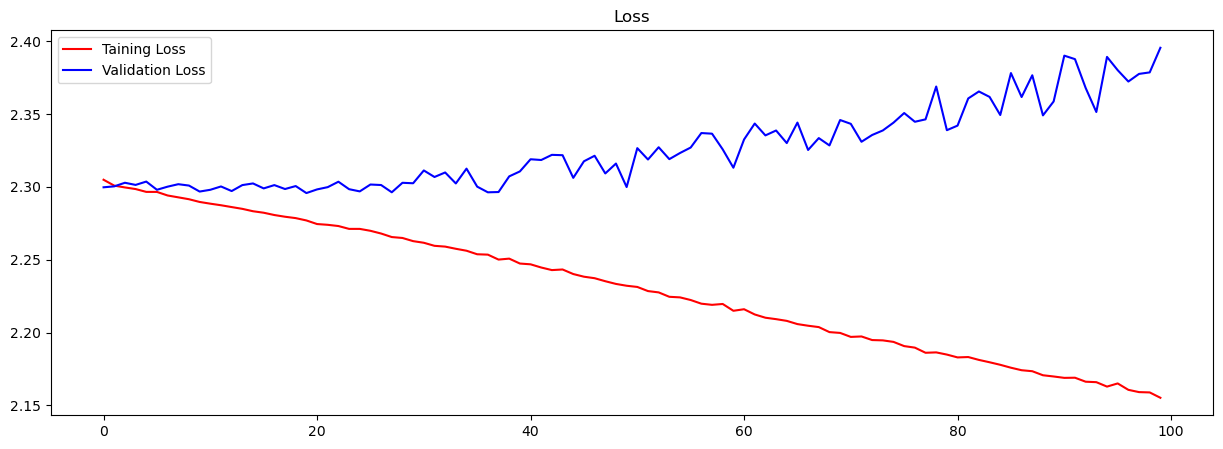

In [10]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,1,1)
ax1.plot(training_loss, 'r-', label='Taining Loss')
ax1.plot(validation_loss, 'b-', label='Validation Loss')
ax1.legend()
ax1.set_title('Loss')

plt.show()
fig.savefig(os.path.join(path2write, 'Random Labels loss.png'))